In [0]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip install notify_run

In [0]:
#!notify-run register

In [0]:
#from notify_run import Notify
#notify = Notify()

# Carga y limpieza de datos

## (Hecho con la info obtenida en el notebook LimpiezaDeDatos)

In [0]:
#import io
#ruta = io.StringIO(uploaded['train.csv'].decode('utf-8'))
ejemplo = pd.read_csv("../content/drive/My Drive/data/ejemploRespuesta.csv", names = ["id", "precio"])
test = pd.read_csv("../content/drive/My Drive/data/test.csv", parse_dates = ['fecha'])
train = pd.read_csv("../content/drive/My Drive/data/train.csv",parse_dates = ['fecha'])
#ejemplo =  pd.read_csv('data/ejemploRespuesta.csv', names = ["id", "precio"] )
#test =  pd.read_csv('data/test.csv', parse_dates = ['fecha'])
#train = pd.read_csv('data/train.csv',parse_dates = ['fecha'])

In [0]:
train=train[['descripcion','precio']]
test=test[['descripcion']]

In [0]:
#train['titulo']=train['titulo'].fillna(' ')
train['descripcion']=train['descripcion'].fillna(' ')
#test['titulo']=test['titulo'].fillna(' ')
test['descripcion']=test['descripcion'].fillna(' ')

In [0]:
train['precio']=train['precio'].astype(np.int32)
#train['id']=train['id'].astype(np.int32)
#test['id']=test['id'].astype(np.int32)

In [0]:
#Algunas columnas tienen nulls que no se como encararlos. Por ahora los relleno con 0
train=train.fillna(0)
test=test.fillna(0)

# Armado de features:

In [0]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [0]:
test.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

In [0]:
promedios_tipodepropiedad=train.groupby('tipodepropiedad')['precio'].mean()

In [0]:
train['tipodepropiedad_mean']=train['tipodepropiedad'].apply(lambda x: promedios_tipodepropiedad[x])
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,tipodepropiedad_mean
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,0.000000,0.000000,2015-08-23,0,0,0,0,0,2273000,2.763769e+06
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10,3,2,2,268,180,24514.0,19.310205,-99.227655,2013-06-28,0,0,0,1,1,3600000,2.898927e+06
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5,3,2,2,144,166,48551.0,0.000000,0.000000,2015-10-17,0,0,0,0,0,1200000,2.398158e+06
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1,2,1,1,63,67,53666.0,19.301890,-99.688015,2012-03-09,0,0,0,1,1,650000,2.398158e+06
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10,2,1,1,95,95,47835.0,0.000000,0.000000,2016-06-07,0,0,0,0,0,1150000,2.763769e+06


In [0]:
#mismo procedimiento anterior para test
test['tipodepropiedad_mean']=test['tipodepropiedad'].apply(lambda x: promedios_tipodepropiedad[x])

In [0]:
promedios_provincia=train.groupby('provincia')['precio'].mean()

In [0]:
train['provincia_mean']=train['provincia'].apply(lambda x: promedios_provincia[x])
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,tipodepropiedad_mean,provincia_mean
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,0.000000,0.000000,2015-08-23,0,0,0,0,0,2273000,2.763769e+06,3.471705e+06
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10,3,2,2,268,180,24514.0,19.310205,-99.227655,2013-06-28,0,0,0,1,1,3600000,2.898927e+06,3.471705e+06
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5,3,2,2,144,166,48551.0,0.000000,0.000000,2015-10-17,0,0,0,0,0,1200000,2.398158e+06,2.367694e+06
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1,2,1,1,63,67,53666.0,19.301890,-99.688015,2012-03-09,0,0,0,1,1,650000,2.398158e+06,2.762465e+06
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10,2,1,1,95,95,47835.0,0.000000,0.000000,2016-06-07,0,0,0,0,0,1150000,2.763769e+06,2.367694e+06


In [0]:
#mismo procedimiento anterior para test
test['provincia_mean']=test['provincia'].apply(lambda x: promedios_provincia[x])

In [0]:
 #Reemplazo las ciudades que estan en test pero no estan en train con un N/A
test[ ~test['ciudad'].isin(train['ciudad'])]['ciudad']=test[ ~test['ciudad'].isin(train['ciudad'])]['ciudad'].apply(lambda x: 'N/A')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
elementos_disjuntos = list(set(test['ciudad'].values.tolist()) - set((train['ciudad'].values.tolist())))

In [0]:
#Cambio las ciudades en test que no estan en train por un N/A
test['ciudad']=test['ciudad'].apply(lambda x: 'N/A' if (x in elementos_disjuntos) else x)

In [0]:
promedios_ciudad=train.groupby('ciudad')['precio'].mean()

In [0]:
train['ciudad_mean']=train['ciudad'].apply(lambda x: promedios_ciudad[x])
#train.head()

In [0]:
#mismo procedimiento anterior para test
test['ciudad_mean']=test['ciudad'].apply(lambda x: promedios_ciudad[x])

En el TP1 vimos como los precios iban en aumento a medida que el tiempo aumentaba, por lo que nos interesa crear nuevos features tomando en cuenta el tiempo en el que se publicaron las propiedades.


Para realizar un nuevo feature comenzaremos añadiendo un peso para cada fecha, este peso irá en aumento a medida que las fechas van subiendo, así simularemos el crecimiento del precio a lo largo del tiempo.

In [0]:
#Califico las fechas de acuerdo a la diferencia entre la fecha actual y la fecha mínima sobre el máximo de dias
fecha_min = train.fecha.min()
fecha_max = train.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
def calificar_fecha(fecha):
    #delta = fecha - fecha_min
    #return delta.days/delta_max_days
    return (fecha.day + fecha.month * 30 + (fecha.year - 2012) * 365)

In [0]:
train.fecha.min().day

1

In [0]:
train["puntaje_por_fecha"] = train['fecha'].transform(lambda x: calificar_fecha(x))
train.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,tipodepropiedad_mean,provincia_mean,ciudad_mean,puntaje_por_fecha
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,8,2,1,2,80,80,23533.0,0.0,0.0,2015-08-23,0,0,0,0,0,2273000,2.763769e+06,3.471705e+06,3.384659e+06,1358


In [0]:
#Set de test
fecha_min = test.fecha.min()
fecha_max = test.fecha.max()
delta_max_days = (fecha_max - fecha_min).days
test["puntaje_por_fecha"] = test['fecha'].transform(lambda x: calificar_fecha(x))
test.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,tipodepropiedad_mean,provincia_mean,ciudad_mean,puntaje_por_fecha
0,4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29,3,2,4,300,176,0.0,19.408668,-99.246767,2013-07-20,0,0,0,0,0,2.398158e+06,3.471705e+06,4.496526e+06,595


## Features descripcion

Para el primer TP descubrimos que habia ciertas palabras que estaban correlacionadas a mayor precio y otras a menor precio. Usando esa informacion vamos a armar features que nos digan si la descripcion tiene o no determinada palabra

In [0]:
#Paso todas las descripciones a minúscula para contar las palabras con mas precision
train['descripcion']=train['descripcion'].apply(lambda x: x.lower())

In [0]:
Palabras_mayor_precio=['cuarto','vestidor','terraza','family','vista','bodega',\
                       'salón','estudio','jardín','room','jacuzzi','lujo','antecomedor',\
                       'tv','fiestas','juegos','estacionamiento','gimnasio','nado',\
                       'lugares','doble','desayunador','servicio','chimenea','visita',\
                       'acabado','espacio','salon','alberca','garden','spa']
Palabras_menor_precio=['minutos','acept','boiler','reja','credito','transporte'\
                      ,'cochera','contado','escuela','inf','fovissste','cerca',\
                      'bancario','protecciones','patio','infonavit']
Palabras=Palabras_mayor_precio + Palabras_menor_precio

In [0]:
dummies_palabras_descr=pd.DataFrame()
#Por cada palabra en la lista genero una columna que diga si la descripcion contenia esa palabra o no
for palabra in Palabras:
    dummies_palabras_descr[palabra]=train['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
#Renombro estas columnas agregandoles un prefijo
dummies_palabras_descr=dummies_palabras_descr.add_prefix('desc_')

In [0]:
dummies_palabras_descr.head(3)

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0


In [0]:
dummies_palabras_descr_test=pd.DataFrame()
#Hago lo mismo para el set de test
for palabra in Palabras:
    dummies_palabras_descr_test[palabra]=test['descripcion'].apply(lambda x: palabra in x).astype(np.int8)
dummies_palabras_descr_test=dummies_palabras_descr_test.add_prefix('desc_')

In [0]:
dummies_palabras_descr_test.head()

,desc_cuarto,desc_vestidor,desc_terraza,desc_family,desc_vista,desc_bodega,desc_salón,desc_estudio,desc_jardín,desc_room,desc_jacuzzi,desc_lujo,desc_antecomedor,desc_tv,desc_fiestas,desc_juegos,desc_estacionamiento,desc_gimnasio,desc_nado,desc_lugares,desc_doble,desc_desayunador,desc_servicio,desc_chimenea,desc_visita,desc_acabado,desc_espacio,desc_salon,desc_alberca,desc_garden,desc_spa,desc_minutos,desc_acept,desc_boiler,desc_reja,desc_credito,desc_transporte,desc_cochera,desc_contado,desc_escuela,desc_inf,desc_fovissste,desc_cerca,desc_bancario,desc_protecciones,desc_patio,desc_infonavit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


## Features titulo

Mismo procedimiento anterior pero para palabras que encontramos correlacionadas a mayor o menor precio en 'titulo'

In [0]:
#Paso todas los titulos a minúscula para contar las palabras con mas precision
train['descripcion']=train['descripcion'].apply(lambda x: x.lower().replace('*',' ').replace('+',' ').replace('.',' ').replace('/',' ').replace('(',' ').replace(')',' ').replace(',',' ').replace('>',' ').replace('<',' '))

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
titulos = train.descripcion.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(titulos)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
119440


In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
tokens = [w for w in tokens if not w in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
frequency_dist = nltk.FreqDist(tokens)

In [0]:
len(frequency_dist)

119226

In [0]:
frecuencias=pd.Series(frequency_dist)

In [0]:
palabras_frecuentes=(frecuencias.nlargest(400)).index.tolist()

In [0]:
palabras_frecuentes

['p',
 ';',
 '&',
 ':',
 '2',
 'baño',
 'casa',
 'cocina',
 'sala',
 '3',
 'recamaras',
 'comedor',
 'nbsp',
 'cuenta',
 '1',
 '!',
 'servicio',
 'planta',
 'dos',
 'cuarto',
 'baños',
 'completo',
 'excelente',
 'estacionamiento',
 'm2',
 'principal',
 'lavado',
 'integral',
 'autos',
 'patio',
 'área',
 'vestidor',
 'terreno',
 'departamento',
 'cochera',
 'terraza',
 '-',
 'recámaras',
 'closet',
 'ntilde',
 'jardín',
 'piso',
 '5',
 'vigilancia',
 'baja',
 'n',
 'ba',
 'venta',
 'recamara',
 'cerca',
 '4',
 'amplia',
 'acabados',
 'alta',
 'medio',
 'zona',
 'aacute',
 'estudio',
 'equipada',
 'li',
 'oacute',
 'niveles',
 'alberca',
 'acceso',
 '24',
 'area',
 'precio',
 'vista',
 'nivel',
 'strong',
 'tres',
 'amplio',
 'construcción',
 'tv',
 'estancia',
 'pisos',
 'fraccionamiento',
 '\x95',
 'espacios',
 'ubicación',
 '$',
 'oportunidad',
 'visitas',
 'bodega',
 'cada',
 'techada',
 'ubicada',
 'jardin',
 'hermosa',
 'minutos',
 'frente',
 'tipo',
 'cisterna',
 'comercial',
 '

In [0]:
X=train[['precio']].copy()

In [0]:
for word in palabras_frecuentes:
  X=X.join(((train['descripcion'].apply(lambda x: word in x)).astype(np.int8)).rename('p_' + word))


In [0]:
X.head()

,precio,p_p,p_;,p_&,p_:,p_2,p_baño,p_casa,p_cocina,p_sala,p_3,p_recamaras,p_comedor,p_nbsp,p_cuenta,p_1,p_!,p_servicio,p_planta,p_dos,p_cuarto,p_baños,p_completo,p_excelente,p_estacionamiento,p_m2,p_principal,p_lavado,p_integral,p_autos,p_patio,p_área,p_vestidor,p_terreno,p_departamento,p_cochera,p_terraza,p_-,p_recámaras,p_closet,...,p_templado,p_pared,p_distribución,p_central,p_muebles,p_tina,p_30,p_sola,p_múltiples,p_previa,p_además,p_zonas,p_porton,p_muros,p_palapa,p_family,p_b,p_garaje,p_propio,p_avenidas,p_familia,p_notario,p_secundarias,p_salida,p_room,p_méxico,p_vías,p_costo,p_uacute,p_buenos,p_vendo,p_real,p_renta,p_escaleras,p_vivir,p_tramitamos,p_minisplit,p_persianas,p_habitación,p_easybroker
0,2273000,1,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3600000,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1200000,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,650000,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1150000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Opcional: me quedo con los mas importantes(el score empeora un poco)
#dummies=dummies[mas_importantes]
#dummies_test=dummies_test[mas_importantes]

## Definiendo X e Y para entrenar y X_test para predecir

In [0]:
Numericos=['antiguedad','habitaciones','garages','banos','metroscubiertos',\
            'metrostotales','gimnasio','usosmultiples','piscina','escuelascercanas',\
            'centroscomercialescercanos','tipodepropiedad_mean','provincia_mean','ciudad_mean','puntaje_por_fecha']

In [0]:
X=X.drop('precio',axis=1)
#X=X.join(dummies)
Y=train['precio']

In [0]:
X.head()

,p_p,p_;,p_&,p_:,p_2,p_baño,p_casa,p_cocina,p_sala,p_3,p_recamaras,p_comedor,p_nbsp,p_cuenta,p_1,p_!,p_servicio,p_planta,p_dos,p_cuarto,p_baños,p_completo,p_excelente,p_estacionamiento,p_m2,p_principal,p_lavado,p_integral,p_autos,p_patio,p_área,p_vestidor,p_terreno,p_departamento,p_cochera,p_terraza,p_-,p_recámaras,p_closet,p_ntilde,...,p_templado,p_pared,p_distribución,p_central,p_muebles,p_tina,p_30,p_sola,p_múltiples,p_previa,p_además,p_zonas,p_porton,p_muros,p_palapa,p_family,p_b,p_garaje,p_propio,p_avenidas,p_familia,p_notario,p_secundarias,p_salida,p_room,p_méxico,p_vías,p_costo,p_uacute,p_buenos,p_vendo,p_real,p_renta,p_escaleras,p_vivir,p_tramitamos,p_minisplit,p_persianas,p_habitación,p_easybroker
0,1,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
Y.shape

(240000,)

In [0]:
Y.head()

0    2273000
1    3600000
2    1200000
3     650000
4    1150000
Name: precio, dtype: int32

In [0]:
X_test = test[Numericos]
#X_test=X_test.join(dummies_test)
X_test.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,tipodepropiedad_mean,provincia_mean,ciudad_mean,puntaje_por_fecha
0,29,3,2,4,300,176,0,0,0,0,0,2.398158e+06,3.471705e+06,4.496526e+06,595
1,8,1,1,1,67,67,0,0,0,0,0,2.763769e+06,2.036020e+06,2.028803e+06,1419
2,0,2,1,2,87,100,0,0,0,0,1,2.763769e+06,3.471705e+06,3.407009e+06,1275
3,2,2,2,2,86,86,0,0,0,0,0,2.763769e+06,2.548742e+06,2.585813e+06,1217
4,10,2,1,1,80,76,0,0,0,1,1,2.398158e+06,2.762465e+06,9.147382e+05,620


In [0]:
#La cantidad de columnas debe matchear en X y X_test
X.shape[1] == X_test.shape[1]

True

# Armado de modelos

In [0]:
def crear_submit(model, x_train, y_train, x_test, nombre):
    model.fit(x_train, y_train)
    result = model.predict(x_test)
    final = test.loc[:, ['id']]
    final['target'] = result
    #ruta = "data/submit"+ nombre +".csv"
    final.to_csv("../content/drive/My Drive/data/submitRF_normalized.csv",index=False)
    #df = pd.read_csv(ruta)
    return final

result=RF_model.predict(X_test_normalized)

---


final = test.loc[:,['id']]
final['target'] = result
final.head()

final.to_csv("../content/drive/My Drive/data/submitRF_normalized.csv",

*   Elemento de la lista
*   Elemento de la lista

index=False)

In [0]:
from sklearn import preprocessing 
def normalizar_data(df):
    min_max_scaler = preprocessing.MinMaxScaler() 
    np_scaled = min_max_scaler.fit_transform(df)
    return pd.DataFrame(np_scaled)

In [0]:
from sklearn.model_selection import cross_val_score

## (1) Random Forest

In [0]:
from sklearn.ensemble  import RandomForestRegressor

RF_model=RandomForestRegressor(random_state=42,n_estimators=80,n_jobs=-1)

### Grafico de importancias

In [0]:
RF_model.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
importancias = pd.DataFrame(RF_model.feature_importances_,index=X.columns,columns=['importancia']).reset_index()
importancias.columns = ['feature', 'importancia']

In [0]:
importancias=importancias.sort_values(by='importancia',ascending=False)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 <a list of 10 Text yticklabel objects>)

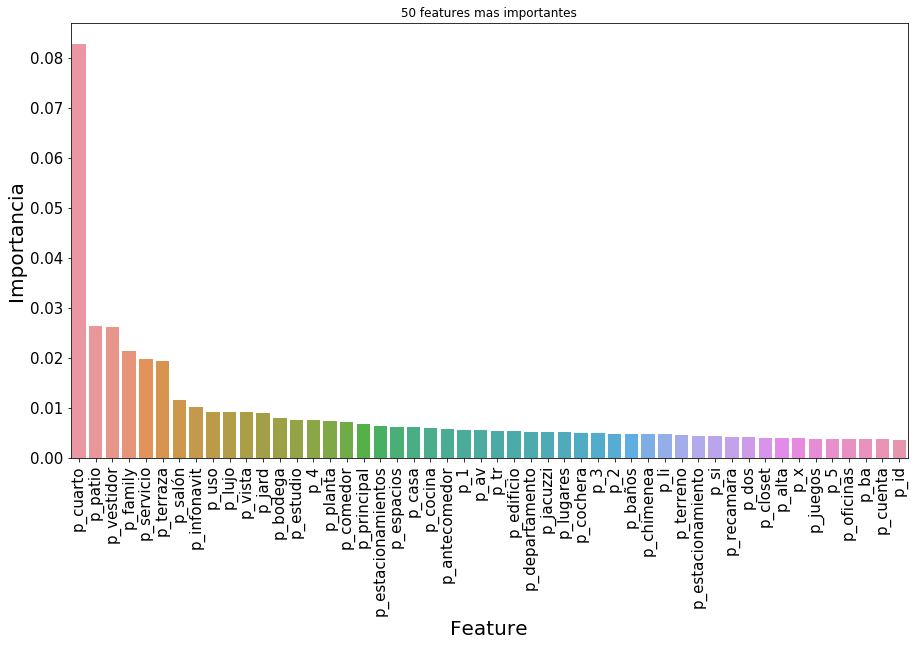

In [0]:
import seaborn as sns
plt.figure(figsize = (15,8))
#Muestro los 50 mas importantes
graf = sns.barplot(x = importancias.feature.head(50), y = importancias.importancia.head(50))
graf.set_title("50 features mas importantes")
graf.set_xlabel("Feature", fontsize = 20)
graf.set_ylabel("Importancia", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 'vertical')
plt.yticks(fontsize = 15)

(array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]),
 <a list of 8 Text yticklabel objects>)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0, flags=flags)


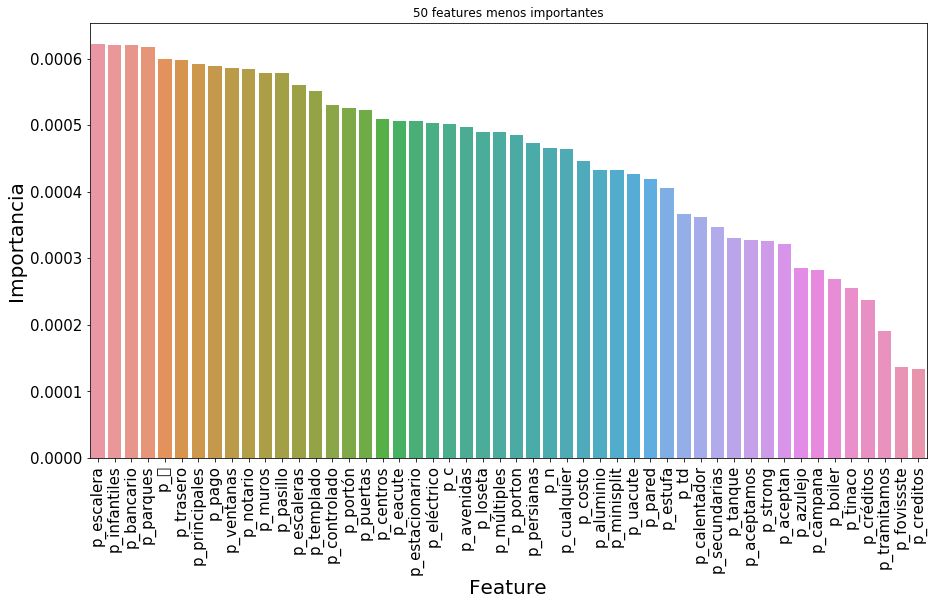

In [0]:

plt.figure(figsize = (15,8))
#Muestro los 50 menos importantes
graf = sns.barplot(x = importancias.feature.tail(50), y = importancias.importancia.tail(50), orient = 'v')
graf.set_title("50 features menos importantes")
graf.set_xlabel("Feature", fontsize = 20)
graf.set_ylabel("Importancia", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 'vertical')
plt.yticks(fontsize = 15)

## Normalizacion

In [0]:
X_normalized = normalizar_data(X)
X_test_normalized = normalizar_data(X_test)
X_test_normalized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.3625,0.222222,0.666667,1.000000,0.672170,0.379717,0.0,0.0,0.0,0.0,0.0,0.350532,1.000000,0.404544,0.309890
1,0.1000,0.000000,0.333333,0.000000,0.122642,0.122642,0.0,0.0,0.0,0.0,0.0,0.441463,0.469103,0.165803,0.762637
2,0.0000,0.111111,0.333333,0.333333,0.169811,0.200472,0.0,0.0,0.0,0.0,1.0,0.441463,1.000000,0.299138,0.683516
3,0.0250,0.111111,0.666667,0.333333,0.167453,0.167453,0.0,0.0,0.0,0.0,0.0,0.441463,0.658701,0.219691,0.651648
4,0.1250,0.111111,0.333333,0.000000,0.153302,0.143868,0.0,0.0,0.0,1.0,1.0,0.350532,0.737733,0.058022,0.323626


# Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
##Me quedo con un sample del 10% para reducir el tiempo de gridsearch
#X_samples=X.join(Y)
#X_samples=X_samples.sample(24000)
#Y_samples=X_samples['precio']
# X_samples=X_samples.drop(['precio'],axis=1)

In [0]:
#X_normalized = normalizar_data(X_samples)

In [0]:
param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto'],
    #'max_depth' : [4,6,8],
    'max_depth' : [None,2,6],
    'criterion' :['mse']
    #'criterion' :['mse', 'mae']
}

In [0]:
CV_rfc = GridSearchCV(estimator=RF_model,scoring="neg_mean_absolute_error", param_grid=param_grid, cv= 2)
CV_rfc.fit(X_normalized, Y)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=80, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['mse'], 'max_depth': [Non

In [0]:
param_grid = { 
    'n_estimators': [80],
    'max_features': ['auto'],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [4,6,8],
    'max_depth' : [None],
    'criterion' :['mse']
    #'criterion' :['mse', 'mae']
}

In [0]:
#CV_rfc = GridSearchCV(estimator=RF_model,scoring="neg_mean_absolute_error", param_grid=param_grid, cv= 2)
#CV_rfc.fit(X_normalized, Y)

In [0]:
#pd.DataFrame(CV_rfc.cv_results_)

# Puntaje de Cross validations con datos normalizados

In [0]:
scores = cross_val_score(RF_model , X, Y, scoring="neg_mean_absolute_error", cv=3)
RF_mae_score1 = -scores.mean()
RF_mae_score1
#614074.6894639914
#1387350.2589699507

In [0]:
-scores

# Creo submit con datos normalizados

In [0]:
submit1 = crear_submit(RF_model,X_normalized, Y, X_test_normalized, "RF_normalized")
submit1.head()

,id,target
0,4941,4.821202e+06
1,51775,1.506079e+06
2,115253,1.774124e+06
3,299321,1.468000e+06
4,173570,8.853857e+05


In [0]:
submit1 = crear_submit(RF_model,X_normalized, Y, X_test_normalized, "RF_normalized")
submit1.head()

,id,target
0,4941,4.880160e+06
1,51775,1.493896e+06
2,115253,1.722756e+06
3,299321,1.290138e+06
4,173570,9.759622e+05


In [0]:
RF_model.score(X,Y)

-5.243266069083889